Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

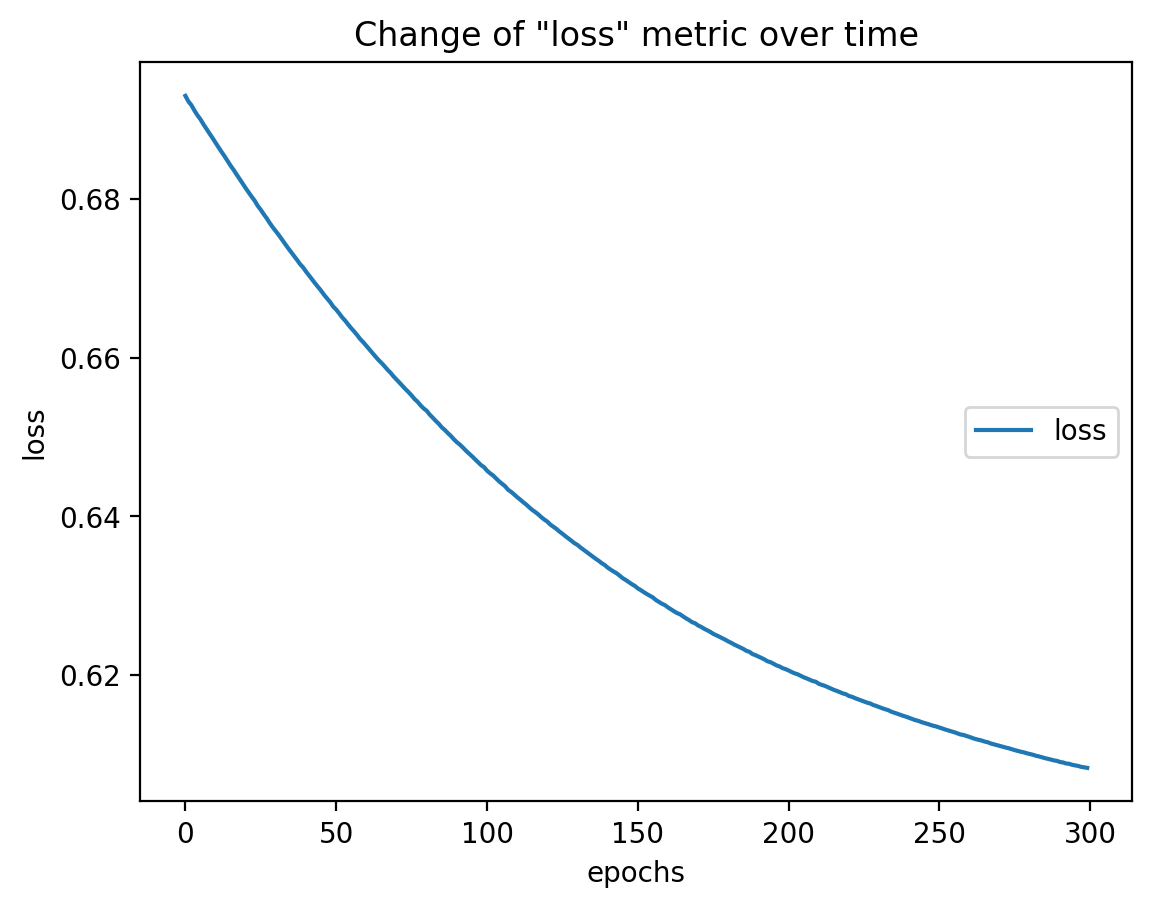

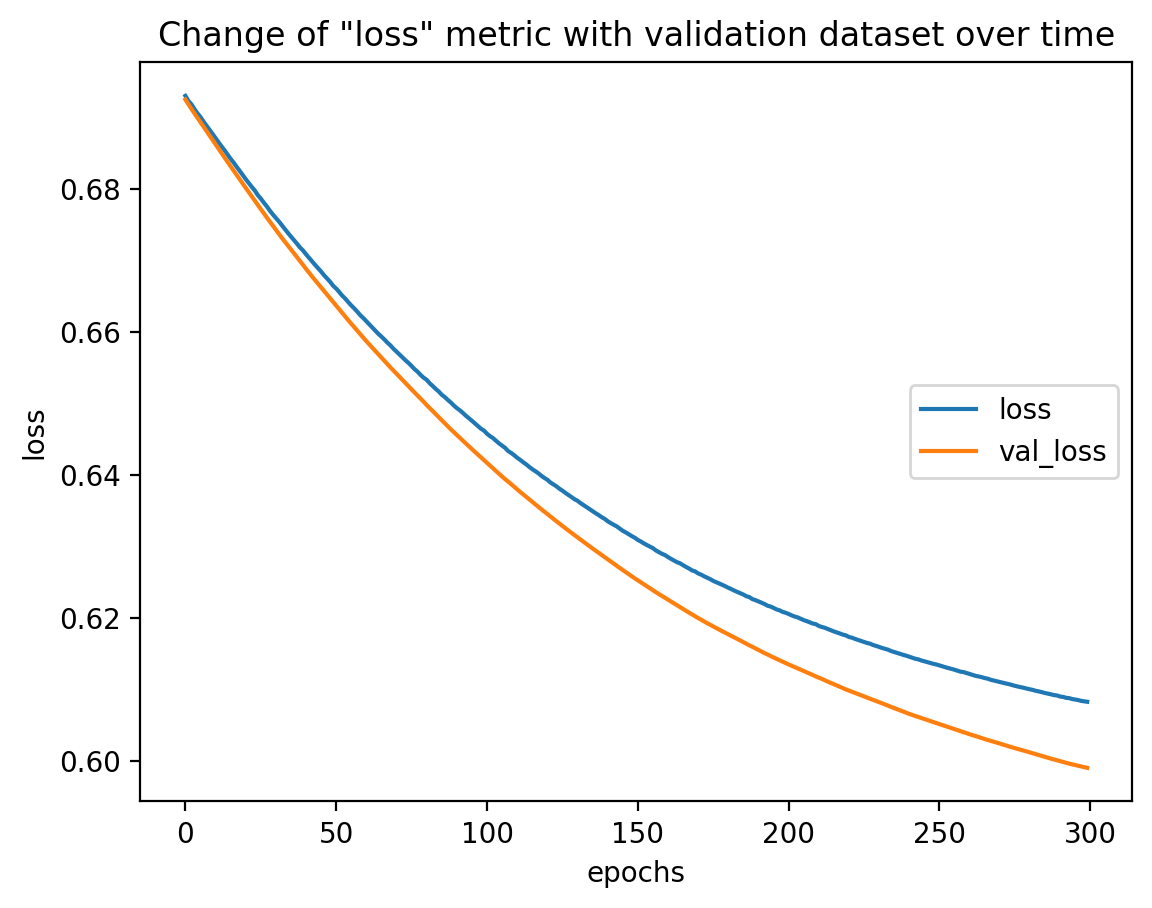

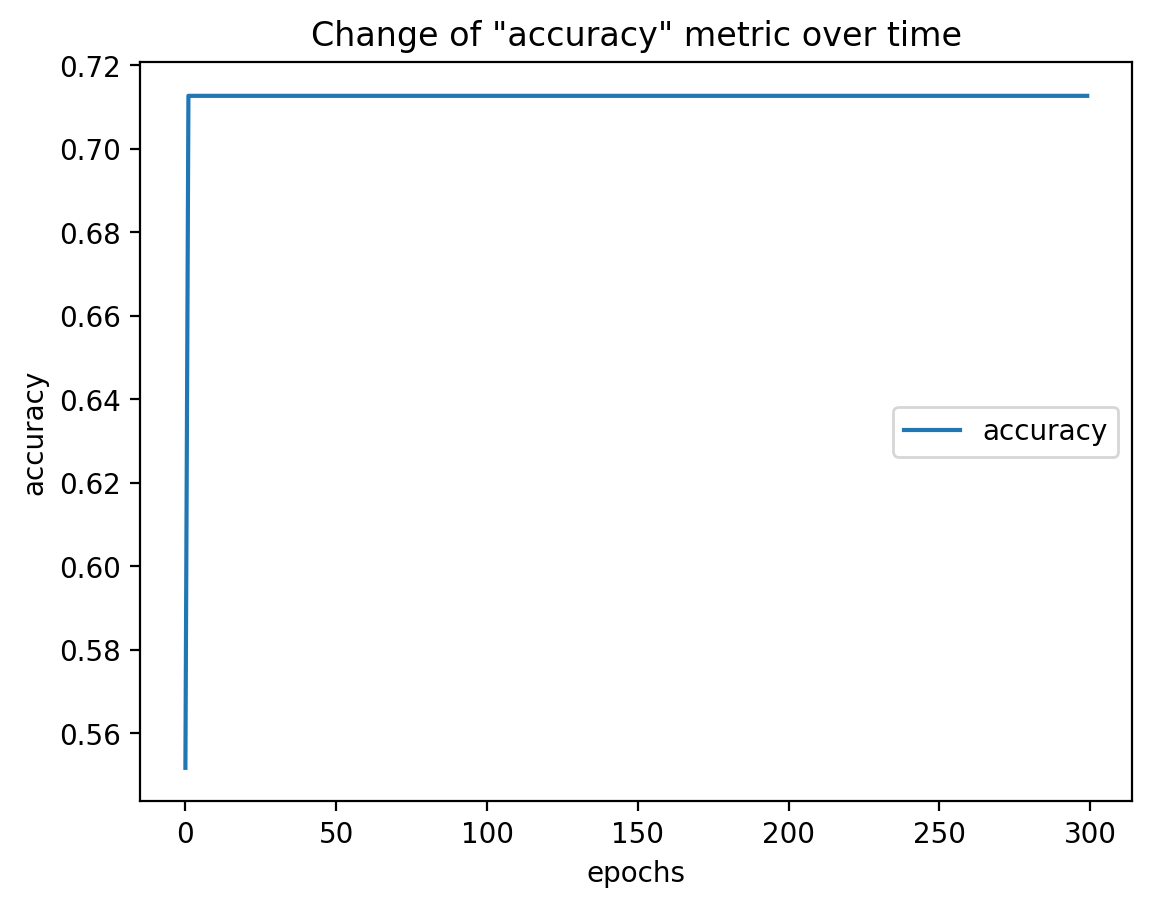

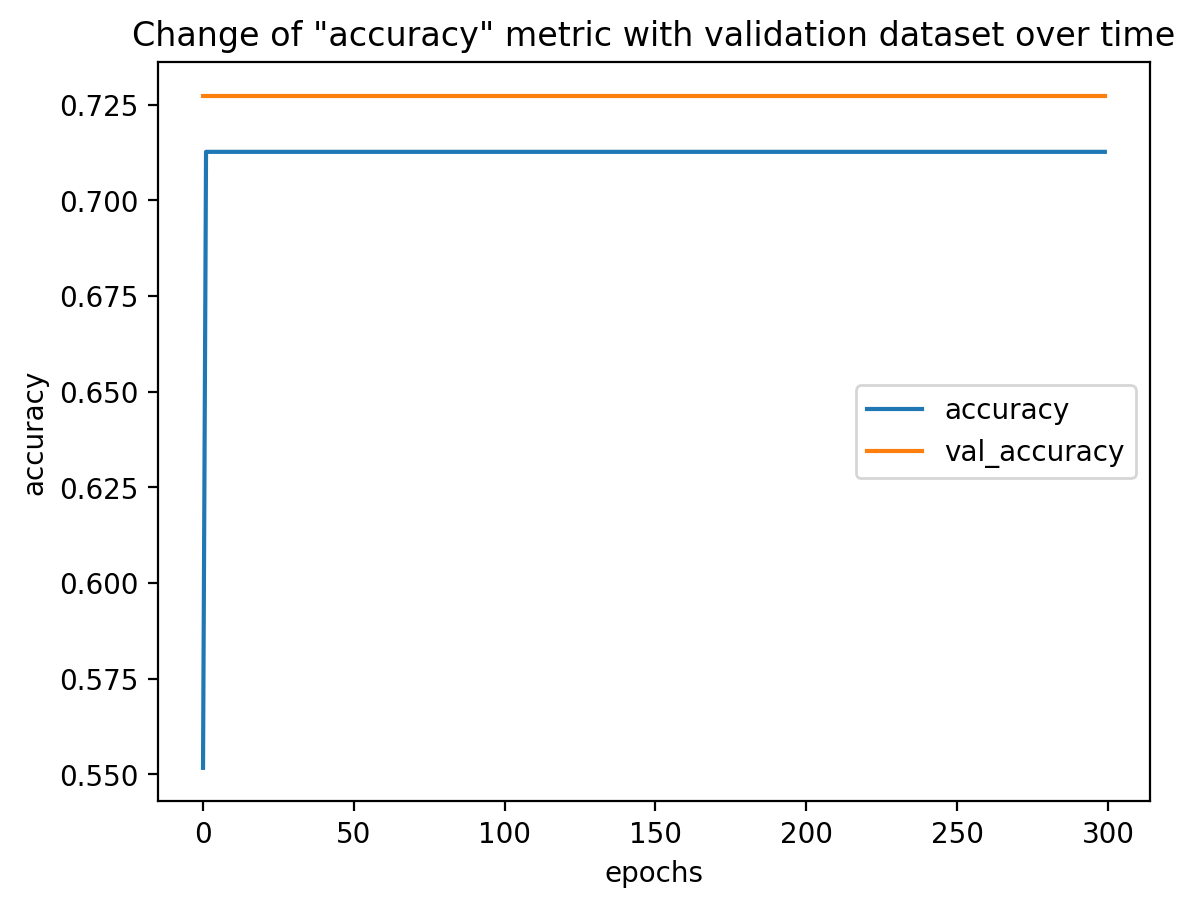


Confusion Matrix:
	---------------------------------
	|	32	|	0	| 
	---------------------------------
	|	12	|	0	|
	---------------------------------

TruePositive	:	32
TrueNegative	:	0
FalsePositive	:	0
FalseNegative	:	12


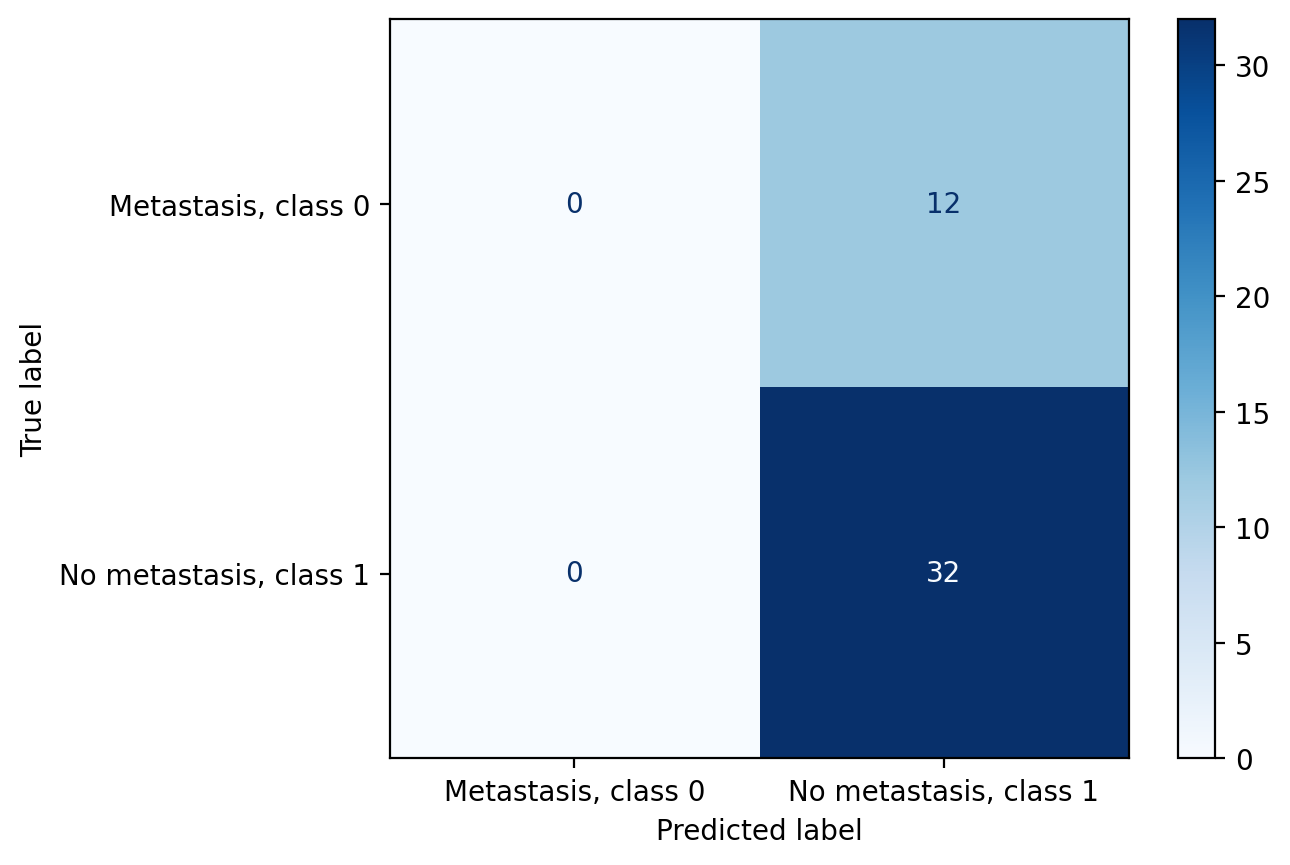

                        precision    recall  f1-score   support

   Metastasis, class 0       0.00      0.00      0.00        12
No metastasis, class 1       0.73      1.00      0.84        32

              accuracy                           0.73        44
             macro avg       0.36      0.50      0.42        44
          weighted avg       0.53      0.73      0.61        44



d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.linear_model import LassoCV

# Wczytanie danych
data = np.genfromtxt("../../data/labels_features.csv", delimiter=",")
data = data[1:, :]

LABELS = data[:, 1].astype(int)  # Tylko klasyfikacja real/fake
FEATURES = data[:, 2:]  # Tylko cechy, bez klasyfikacji
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

# Użycie Lasso do selekcji cech
lasso = LassoCV(cv=2)
lasso.fit(FEATURES, LABELS)

# Wybór cech, których współczynniki są różne od zera
selected_features = np.where(lasso.coef_ != 0)[0]
FEATURES = FEATURES[:, selected_features]

# Podział na zbiory treningowe i testowe
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(FEATURES, LABELS, test_size=test_size, random_state=42)

# Konwersja etykiet do formatu kategorycznego
num_labels = len(np.unique(LABELS))
y_cat_train = to_categorical(y_train, num_labels)
y_cat_test = to_categorical(y_test, num_labels)

# Skalowanie cech
scaler_object = MinMaxScaler()
scaler_object.fit(x_train)
x_train = scaler_object.transform(x_train)
x_test = scaler_object.transform(x_test)

# Przekształcenie cech dla modelu
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

x_train_shape = x_train[0].shape
x_test_shape = x_test[0].shape

# Tworzenie modelu
model = Sequential()
# model.add(Conv1D(filters=128, kernel_size=3, input_shape=x_train_shape, activation="relu", name="Conv1D_1"))
# model.add(Dropout(0.5, name="Dropout_C_1"))
# model.add(MaxPool1D(pool_size=2, strides=2, name="MaxPool1D"))
model.add(Conv1D(filters=8, kernel_size=1, activation="relu", name="Conv1D_1"))
model.add(Conv1D(filters=4, kernel_size=1, activation="relu", name="Conv1D_4"))
model.add(Flatten(name="Flatten"))
# model.add(Dense(64, activation="relu", name="Dense_3"))
# model.add(Dropout(0.5, name="Dropout_D_1"))
model.add(Dense(4, activation="relu", name="Dense_4"))
model.add(Dense(1, activation="sigmoid", name="Output"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

epochs = 300
withVal = True

# Callbacki
monitor = "loss"
checkpoint = ModelCheckpoint("../../models/feature_selection/embedded_method_best_model.h5", monitor=monitor, save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor=monitor, patience=3, restore_best_weights=True)

trainData = x_train
testData = x_test

if withVal:
    results = model.fit(trainData, y_train, epochs=epochs, verbose=3, validation_data=(testData, y_test), callbacks=[checkpoint, early_stopping])
else:
    results = model.fit(x_train, y_train, epochs=epochs, verbose=3)

metric_names = model.metrics_names
scores = model.evaluate(testData, y_test, verbose=0)

print("Metrics:")
for i, name in enumerate(metric_names):
    print("\t%s:   \t%.2f" % (name, scores[i]))

def plot_metric(metric: str, withVal: bool = False) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel("epochs")
    plt.ylabel(metric)

    ax.plot(results.history[metric], label=metric)
    if withVal:
        plt.title(f'Change of "{str(metric)}" metric with validation dataset over time')
        ax.plot(results.history["val_" + str(metric)], label="val_" + str(metric))
    else:
        plt.title(f'Change of "{metric}" metric over time')
    plt.legend(loc="center right")
    plt.show(block=False)

for name in metric_names:
    plot_metric(name)
    if withVal:
        plot_metric(name, withVal)

predictions = (model.predict(testData, verbose=0) > 0.5).astype("int32")

conf_mat = confusion_matrix(y_test, predictions)
confusion = {
    "TruePositive": conf_mat[1][1],
    "TrueNegative": conf_mat[0][0],
    "FalsePositive": conf_mat[1][0],
    "FalseNegative": conf_mat[0][1],
}
accuracy = scores[1]
accuracy = round(accuracy * 100, 2)

def printDict(obj: dict[str, int] = "") -> None:
    if isinstance(obj, dict):
        for k, v in obj.items():
            if hasattr(v, "__iter__"):
                print(k)
                printDict(v)
            else:
                print("%s\t:\t%s" % (k, v))
    elif isinstance(obj, list):
        for v in obj:
            if hasattr(v, "__iter__"):
                printDict(v)
            else:
                print(v)
    else:
        print(obj)

separator = "\t---------------------------------\n"
matrixConfusion = f'\nConfusion Matrix:\n{separator}\t|\t{confusion["TruePositive"]}\t|\t{confusion["FalsePositive"]}\t| \n{separator}\t|\t{confusion["FalseNegative"]}\t|\t{confusion["TrueNegative"]}\t|\n{separator}'
print(matrixConfusion)
printDict(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=TARGET_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(y_test, predictions, target_names=TARGET_NAMES)
print(report)


In [49]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 1, 8)              16        
                                                                 
 Conv1D_4 (Conv1D)           (None, 1, 4)              36        
                                                                 
 Flatten (Flatten)           (None, 4)                 0         
                                                                 
 Dense_4 (Dense)             (None, 4)                 20        
                                                                 
 Output (Dense)              (None, 1)                 5         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
